In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as RAF

import work


<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [4]:
file_name = "TB_FIRE_1101_hits.root"
hit_data_1101 = RAF.get_ROOT_data_zip(file_name)

Folders: ['Hits;1']

Hits:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TLU_number           | uint64_t                 | AsDtype('>u8')
timestamp            | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
plane_ID             | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
ch_ID                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
amplitude            | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
toa                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


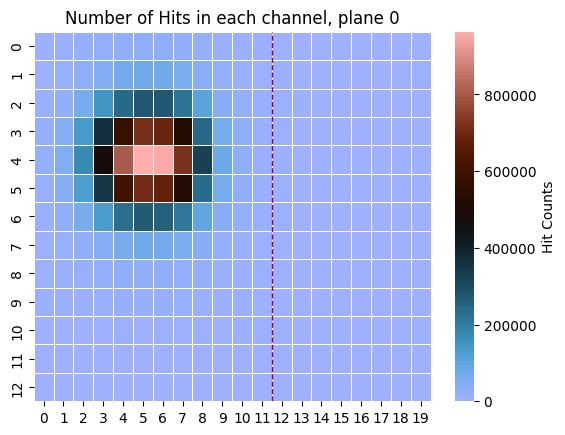

In [ ]:
RAF.hits_amount_colormap_single_plane(hit_data_1101, 0)

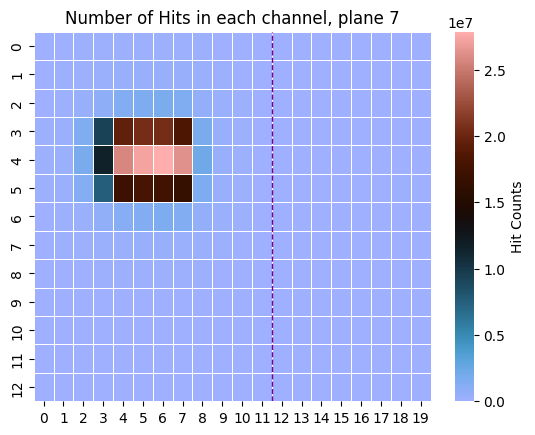

In [ ]:
RAF.hits_amp_colormap_single_plane(hit_data_1101, 7)

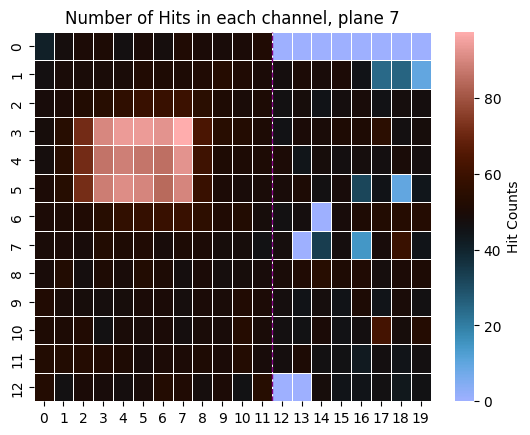

In [5]:
RAF.average_amp_colormap_single_plane(hit_data_1101, 7)

In [20]:

# gets data and returns for a specific plane: pads_2d - the pads with signals in 2d coordinates ; counts- amount of hits on each pad
def plane_hit_counts(hit_data, plane):
    # get only the hits on the wanted plane
    hits_plane = hit_data[hit_data.plane == plane]

    # get only the channels data and clean the array from empty cells
    clean_plane_ch = hits_plane.ch[ak.num(hits_plane.ch) > 0]

    # count the amount of hits in each pad on the plane
    pads_1d, counts = np.unique(ak.flatten(clean_plane_ch), axis=0, return_counts=True)

    # convert the 1d index of the pads into 2d coordinates
    pads_2d = divmod(pads_1d, 20)    

    return pads_2d, counts


In [82]:
# Shows the shower evolution of a SINGLE EVENT in the sensor
def single_event_evolution(hit_data, TLU_number, cmap="berlin"):

    # get the path of the specific event
    TLU_event_data = hit_data[TLU_number]

    
    # count the amount of hits of each pad in every plane
    for plane in range(7,-1,-1):
        
        # get the channels hits on the wanted plane
        hits_plane = TLU_event_data[TLU_event_data.plane == plane].ch

        # create channel(pads) matrix
        counts_matrix = np.zeros((13, 20))
        
        # modify the pads matrix only if there are any hits on the plane
        if len(hits_plane) != 0:
            # count the amount of hits in each pad on the plane
            pads_1d, counts = np.unique(hits_plane, return_counts=True)

            # convert the 1d index of the pads into 2d coordinates
            pads_2d = divmod(pads_1d, 20)    

    
            # distribute the counts for each pad on a 12x20 matrix
            counts_matrix = np.zeros((13, 20))
            for i in range(len(pads_1d)):
                q = pads_2d[0][i]           # quotinent of the i'th pad (row from bottom)
                r = pads_2d[1][i]           # remainder of the i'th pad (column)
                counts_matrix[-1-q][r] = counts[i]
                

        
        # creat the colormap
        seaborn.heatmap(counts_matrix, cmap=cmap, linewidths=0.5, cbar_kws={'label': 'Hit Counts'})
        plt.title(f'Number of Hits in each channel, plane {7-plane}')
        plt.axvline(x=12, color='purple', linestyle='--', linewidth=1)
        plt.show()


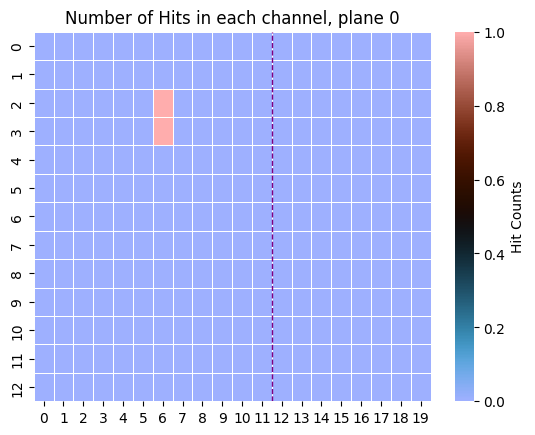

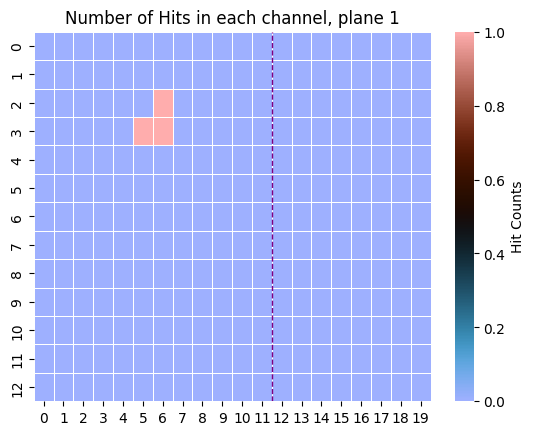

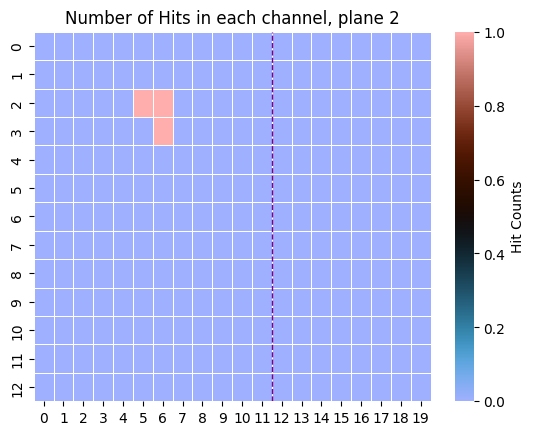

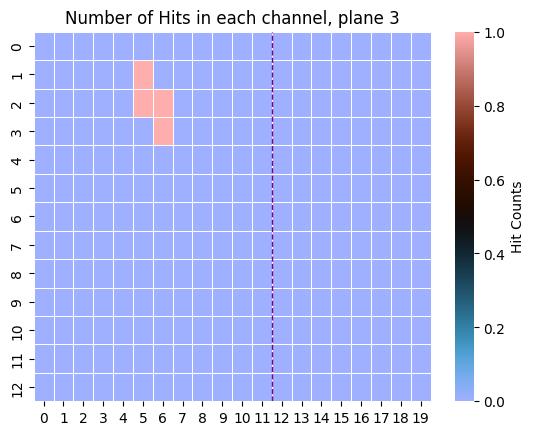

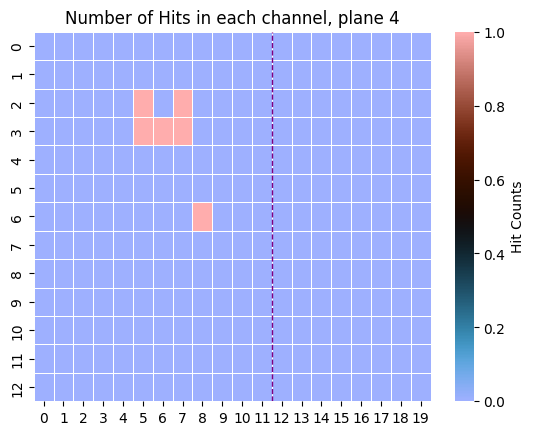

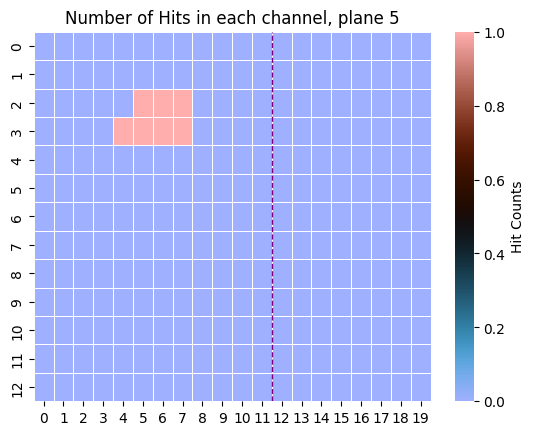

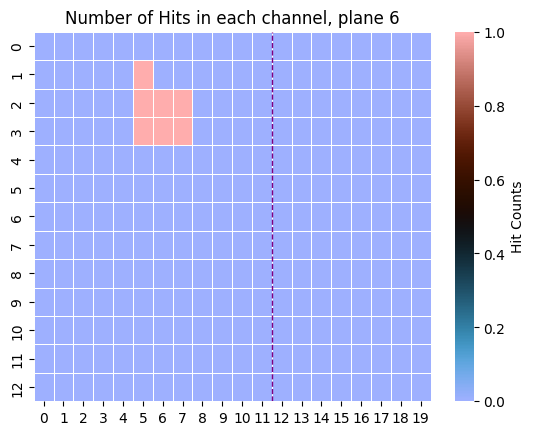

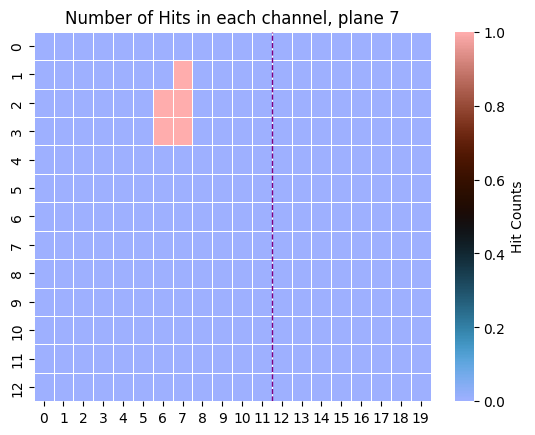

In [87]:
single_event_evolution(hit_data_1101, 12)

In [74]:
for plane in range(8,-1,-1):
    print(plane)

8
7
6
5
4
3
2
1
0
